# Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import pandas as pd
import numpy as np
import os
import io
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-04-09 06:40:52.720447: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.720588: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.720749: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.720830: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.720918: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.721128: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-09 06:40:52.721219: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8


In [82]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 25

print(BATCH_SIZE)

512


# Data Loading

In [52]:
paths = []
labels = []

df = pd.read_csv("/kaggle/input/cassava-leaf-disease-classification/train.csv")

for i in df["image_id"]:
    paths.append(i)

for i in df["label"]:
    labels.append(i)

print(paths[:10])
print(labels[:10])
df

['1000015157.jpg', '1000201771.jpg', '100042118.jpg', '1000723321.jpg', '1000812911.jpg', '1000837476.jpg', '1000910826.jpg', '1001320321.jpg', '1001723730.jpg', '1001742395.jpg']
[0, 3, 1, 1, 3, 3, 2, 0, 4, 3]


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


# No TFRecord Files

In [53]:
# Create a dataset of file paths
image_dataset = tf.data.Dataset.from_tensor_slices(paths)

# Function to load and preprocess each image
def load_and_preprocess(path):
    image = tf.io.read_file("/kaggle/input/cassava-leaf-disease-classification/train_images/" + path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [512, 512])
    return image

# Create image dataset
image_dataset = image_dataset.map(load_and_preprocess)

# Create dataset for labels
label_dataset = tf.data.Dataset.from_tensor_slices(labels)

dataset_no_tfrecord = tf.data.Dataset.zip((image_dataset, label_dataset))


train_split = 0.9
val_split = 0.1

train_num = int(len(labels)*train_split)
val_num = int(len(labels)*val_split)

# make sure to get all the number of training examples in the dataset
if not train_num + val_num == len(labels):
    train_val_num = train_num + val_num
    leftovers = len(labels) - train_val_num
    val_num += leftovers

# sanity check
if train_num + val_num == len(labels):
    print("train_num plus val_num does equal the number of training examples")

if not train_num + val_num == len(labels):
    print("train_num plus val_num does not equal the number of training examples")

train_dataset_no_tfrecord = dataset_no_tfrecord.take(train_num)
val_dataset_no_tfrecord = dataset_no_tfrecord.skip(train_num)


train_dataset_no_tfrecord = train_dataset_no_tfrecord.cache().batch(batch_size = BATCH_SIZE).map(lambda x, y: (x/255, y)).shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_dataset_no_tfrecord = val_dataset_no_tfrecord.cache().batch(batch_size = BATCH_SIZE).map(lambda x, y: (x/255, y)).shuffle(500).prefetch(buffer_size=AUTOTUNE)

print("\nTraining data shapes:", train_dataset_no_tfrecord)
print("\nValidation data shapes:", val_dataset_no_tfrecord)

train_num plus val_num does equal the number of training examples

Training data shapes: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Validation data shapes: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Model

In [6]:
# mixed-precision training
mixed_precision.set_global_policy('mixed_float16')


with strategy.scope():
    
    model = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
    model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

I0000 00:00:1712545010.163198      13 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             

 Total params: 237,573 (928.02 KB)

 Trainable params: 237,573 (928.02 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(train_dataset_no_tfrecord, epochs=EPOCHS, validation_data=val_dataset_no_tfrecord)

Epoch 1/25


2024-04-08 02:57:19.610586: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.635210: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.658740: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.681409: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.705125: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.728505: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 02:57:19.751738: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 4.3292 - loss: 11.1691

2024-04-08 02:59:03.635252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
2024-04-08 02:59:07.953893: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 4.2334 - loss: 10.9163 - val_accuracy: 0.6119 - val_loss: 1.2804
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 4.9194 - loss: 9.4557

2024-04-08 03:00:24.730148: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.8092 - loss: 9.2430 - val_accuracy: 0.6119 - val_loss: 1.3152
Epoch 3/25


2024-04-08 03:00:35.542134: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.8318 - loss: 9.0072 - val_accuracy: 0.6082 - val_loss: 1.2848
Epoch 4/25


2024-04-08 03:01:40.609292: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-08 03:01:40.610020: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 4.9557 - loss: 8.9263

2024-04-08 03:02:40.051816: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.8447 - loss: 8.7256 - val_accuracy: 0.6082 - val_loss: 1.2089
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 4.9175 - loss: 8.4504 - val_accuracy: 0.6231 - val_loss: 1.1840
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 4.9200 - loss: 8.3918 - val_accuracy: 0.6231 - val_loss: 1.1638
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.9776 - loss: 7.9733 - val_accuracy: 0.6157 - val_loss: 1.1516
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.9896 - loss: 7.8830 - val_accuracy: 0.6231 - val_loss: 1.2267
Epoch 9/25


2024-04-08 03:07:07.918832: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.9755 - loss: 7.7748 - val_accuracy: 0.6157 - val_loss: 1.1582
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.9657 - loss: 7.7516 - val_accuracy: 0.6231 - val_loss: 1.1056
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 5.0458 - loss: 7.5224 - val_accuracy: 0.6343 - val_loss: 1.1900
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 5.0717 - loss: 7.3739 - val_accuracy: 0.6269 - val_loss: 1.2102
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 5.1689 - loss: 7.2333 - val_accuracy: 0.6381 - val_loss: 0.9857
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 5.1642 - loss: 7.0859 - val_accuracy: 0.6231 - val_loss: 1.0568
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 5.2584 - loss: 7.0075 - val_accuracy: 0.5933 - val_loss: 1.2099
Epoch 16/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 5.2717 - loss: 6.8909 - val_accuracy: 0.6045 - val_loss: 1.1

2024-04-08 03:19:02.464537: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 5.3702 - loss: 6.4351 - val_accuracy: 0.6381 - val_loss: 1.0682
Epoch 20/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 5.4317 - loss: 6.3228 - val_accuracy: 0.6269 - val_loss: 0.9916
Epoch 21/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 5.4681 - loss: 6.1586 - val_accuracy: 0.5858 - val_loss: 1.1900
Epoch 22/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 5.5194 - loss: 6.0268 - val_accuracy: 0.6306 - val_loss: 1.0205
Epoch 23/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 5.6310 - loss: 5.8104 - val_accuracy: 0.6194 - val_loss: 0.9901
Epoch 24/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 5.7266 - loss: 5.5391 - val_accuracy: 0.5784 - val_loss: 1.0439
Epoch 25/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 5.8716 - loss: 5.1678 - val_accuracy: 0.5037 - val_loss: 1.2585


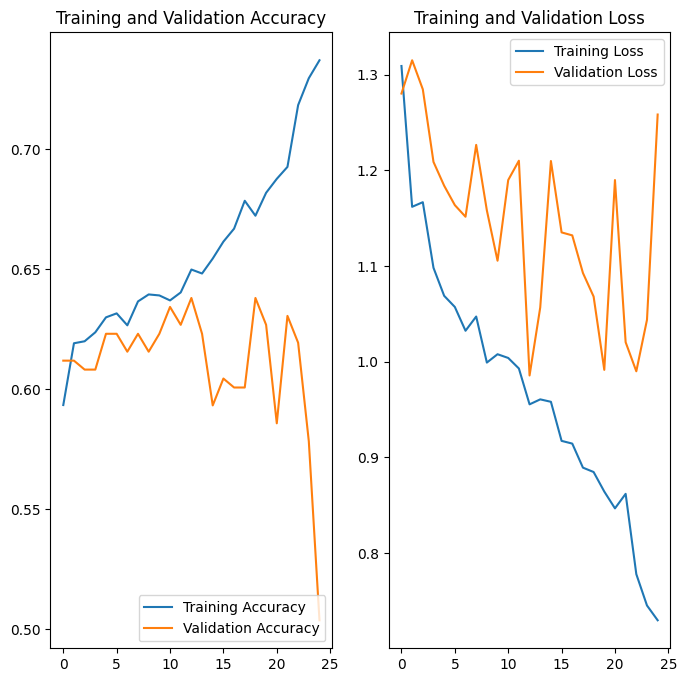

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
with open("rpu_baseline_model1_acc_25_epochs", "w") as f:
    for a in acc:
        f.write(str(a) + "\n")
        
with open("rpu_baseline_model1_val_acc_25_epochs", "w") as f:
    for v in val_acc:
        f.write(str(v) + "\n")


tf.saved_model.save(model, "rpu_baseline_model1_25_epochs")

INFO:tensorflow:Assets written to: rpu_baseline_model1_25_epochs/assets


INFO:tensorflow:Assets written to: rpu_baseline_model1_25_epochs/assets


# Random Parameter Update

### RPU

In [25]:
def rpu(arr, range_up, portion_up, layer_num):
    
    # get the length of the shape of the layer
    shape_length = len(arr[layer_num].shape)
    
    # number of elements in a layer's weights to update
    portion_up_num = int(portion_up * arr[layer_num].size)
    
    # parameter updates
    updates = list(np.random.uniform(*range_up, size = portion_up_num))
    
    # elements' indices
    idxs = []

    
    # if layer has 4 indices
    
    if shape_length == 4:
        
        # get indices for each element
        for i in range(portion_up_num):
            idx1 = np.random.randint(0, arr[layer_num].shape[0])
            idx2 = np.random.randint(0, arr[layer_num].shape[1])
            idx3 = np.random.randint(0, arr[layer_num].shape[2])
            idx4 = np.random.randint(0, arr[layer_num].shape[3])
    
            idxs.append([idx1, idx2, idx3, idx4])
            
                
        # update each element
        for idx, update in zip(idxs, updates):
            arr[layer_num][idx[0], idx[1], idx[2], idx[3]] += update
                
                
    
    # if layer has 2 indices
    
    elif shape_length == 2:
        
        # get indices for each element
        for i in range(portion_up_num):
            idx1 = np.random.randint(0, arr[layer_num].shape[0])
            idx2 = np.random.randint(0, arr[layer_num].shape[1])

            idxs.append([idx1, idx2])
        
        # update each element
        for idx, update in zip(idxs, updates):
            arr[layer_num][idx[0], idx[1]] += update
            
            
            
    else:
        print("Wrong shape_length:", shape_length)
    
    
    return arr

### Digress Algorithm

In [26]:
def digress(acc_discrepancy, acc_threshold, window):
    
    evaluations = [discrepant > acc_threshold for discrepant in acc_discrepancy[-(window):]]
    discrepant_counts = len(list(filter(lambda x: x == True, evaluations)))
    
    return discrepant_counts

### Sanity Checks

In [ ]:
############
# for layer_num in range(0, len(saved_model.get_weights()), 2):
    
#     saved_weights = rpu(saved_weights, range_up, portion_up, layer_num)
    

############
# print(saved_weights[-1] == saved_model.get_weights()[-1])



############
# falses = 0

# mod = []

# for i in range(len(saved_weights)):
#     mod + [element for element in np.nditer(saved_weights[i])]
    
# orig = []

# for i in range(len(saved_model.get_weights())):
#     orig + [element for element in np.nditer(saved_model.get_weights()[i])]
    

# for m, o in zip(mod, orig):
#     if m != o:
#         falses += 1

# print(falses)



############
# # shapes

# for i in saved_weights:
#     print(i.shape)

### CNN & RPU Model

In [40]:
# mixed-precision training
mixed_precision.set_global_policy('mixed_float16')


with strategy.scope():
    
    model = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
    model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])



    
with strategy.scope():
    
    model_rpu = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
    model_rpu.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [22]:
model.summary()

model_rpu.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             

 Total params: 237,573 (928.02 KB)

 Trainable params: 237,573 (928.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 510, 510, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 124, 124, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             

 Total params: 237,573 (928.02 KB)

 Trainable params: 237,573 (928.02 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [87]:
# hyperparameters
range_up = (-0.05, 0.05)
portion_up = 0.50
acc_threshold = 0.02
window = 2
initial_epoch = 0
acceptable_random_update_train_acc = 0.02
random_update_search = 0.03

# containers
acc_discrepancy = []
train_accuracies = []
val_accuracies = []
train_accuracies_rpu = []
val_accuracies_rpu = []

# initial values
rpu_training = False
attempt = 1

In [38]:
for i in range(EPOCHS):
    
    print("\nNORMAL TRAINING:", "EPOCH", i+1)
    
    history = model.fit(train_dataset_no_tfrecord, epochs=1, validation_data=val_dataset_no_tfrecord)
    
    acc_discrepancy.append(abs(history.history["accuracy"][0] - history.history["val_accuracy"][0]))
    
    discrepant_counts = digress(acc_discrepancy, acc_threshold, window)
    
    print("acc:", history.history["accuracy"][0])
    print("val_acc:", history.history["val_accuracy"][0])
    print("loss:", history.history["loss"][0])
    print("val_loss:", history.history["val_loss"][0])
    print("discrepant_counts:", discrepant_counts)
    
    if discrepant_counts == window:
        
        print("\nRPU TRAINING")
        
        while True:
        
            print("\nattempt:", attempt, "\n")

            params = model.get_weights()

            for layer_num in range(0, 18, 2):
                params = rpu(params, range_up, portion_up, layer_num)

            model_rpu.set_weights(params)

            train_acc_rpu = model_rpu.evaluate(train_dataset_no_tfrecord)
            val_acc_rpu = model_rpu.evaluate(val_dataset_no_tfrecord)

            acc_discrepancy_rpu = abs(train_acc_rpu[1] - val_acc_rpu[1])
            loss_discrepancy_rpu = abs(train_acc_rpu[0] - val_acc_rpu[0])

            print("acc_rpu:", train_acc_rpu[1])
            print("val_acc_rpu:", val_acc_rpu[1])
            print("loss_rpu:", train_acc_rpu[0])
            print("val_loss_rpu:", val_acc_rpu[0])
            print("acc_discrepancy_rpu:", acc_discrepancy_rpu)
            print("loss_discrepancy_rpu:", loss_discrepancy_rpu)

            attempt += 1
            
            if (acc_discrepancy_rpu <= acc_threshold) and (train_acc_rpu[1] > history.history["accuracy"][0]):
                
                model.set_weights(params)
                rpu_training = True
                attempt = 1
                
                break
            
            # assuming that the acc_discrepancy in normal training is too large
            if (acc_discrepancy_rpu <= random_update_search) and (abs(train_acc_rpu[1] - history.history["accuracy"][0]) <= acceptable_random_update_train_acc):
                model.set_weights(params)
                print("accepted random update")
                continue
    
    if not rpu_training:
        train_accuracies.append(history.history["accuracy"][0])
        val_accuracies.append(history.history["val_accuracy"][0])

    if rpu_training:
        train_accuracies.append(train_acc_rpu[1])
        val_accuracies.append(val_acc_rpu[1])
        rpu_training = False


NORMAL TRAINING: EPOCH 1


2024-04-09 04:11:08.017335: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 4.9427 - loss: 10.7150

2024-04-09 04:12:30.219622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 4.8318 - loss: 10.4749 - val_accuracy: 0.6119 - val_loss: 1.2927
acc: 0.6158638000488281
val_acc: 0.611940324306488
loss: 1.3524612188339233
val_loss: 1.2927011251449585
discrepant_counts: 0

NORMAL TRAINING: EPOCH 2
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 4.7955 - loss: 9.2702 - val_accuracy: 0.6119 - val_loss: 1.2832
acc: 0.6191860437393188
val_acc: 0.611940324306488
loss: 1.1824133396148682
val_loss: 1.2831672430038452
discrepant_counts: 0

NORMAL TRAINING: EPOCH 3
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 4.8182 - loss: 8.9597 - val_accuracy: 0.6119 - val_loss: 1.1986
acc: 0.6191860437393188
val_acc: 0.611940324306488
loss: 1.140386700630188
val_loss: 1.1986217498779297
discrepant_counts: 0

NORMAL TRAINING: EPOCH 4
38/38 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 4.8197 - loss: 8.6636 - val_accuracy: 0.6119 - val_loss: 1.2398
acc: 0.6191860437393188
val_acc: 0.611940324306488
loss: 1.1174014806747437
val_los

2024-04-09 04:24:05.673708: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 4.4275 - loss: 10.2055
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 3.8490 - loss: 8.9027
acc_rpu: 0.5751661062240601
val_acc_rpu: 0.5746268630027771
loss_rpu: 1.3002265691757202
val_loss_rpu: 1.2968436479568481
acc_discrepancy_rpu: 0.000539243221282959
loss_discrepancy_rpu: 0.0033829212188720703
attempt: 2
38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 3.9002 - loss: 10.7676
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 3.4702 - loss: 9.3745 
acc_rpu: 0.5132890343666077
val_acc_rpu: 0.5
loss_rpu: 1.3718104362487793
val_loss_rpu: 1.3702274560928345
acc_discrepancy_rpu: 0.013289034366607666
loss_discrepancy_rpu: 0.0015829801559448242
attempt: 3
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 4.0386 - loss: 10.5520
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 3.5498 - loss: 9.2194 
acc_rpu: 0.5265780687332153
val_acc_rpu: 0.5261194109916687
loss_rpu: 1.343397855758667
val_loss_rpu: 1.342052698135376
acc_discrepancy_rpu: 0

KeyboardInterrupt: 

In [ ]:
with open("rpu_nonbaseline_model1_acc_25_epochs", "w") as f:
    for acc in train_accuracies:
        f.write(str(acc) + "\n")

with open("rpu_nonbaseline_model1_val_acc_25_epochs", "w") as f:
    for val in val_accuracies:
        f.write(str(val) + "\n")
        
model.save("rpu_nonbaseline_model1_25_epochs")
# you can save the entire model using: tf.saved_model.save(model, filename), model.save(filename)

### Continue RPU

In [ ]:
rpu_training = False
attempt = 1


print("\nRPU TRAINING")

# Pure RPU

In [88]:
# for entire models

import shutil

# Define source and destination paths
src_path = r"/kaggle/input/trained_model1.keras/keras/eight/1/trained_model8_200_epochs_entire.keras"
dst_path = r"/kaggle/working/"

# Copy the file
shutil.copy(src_path, dst_path)

saved_model = tf.keras.models.load_model('/kaggle/working/trained_model8_200_epochs_entire.keras')

In [89]:
# mixed-precision training
mixed_precision.set_global_policy('mixed_float16')


with strategy.scope():
    
    model = models.Sequential([layers.Input(shape=(512, 512, 3)),
                               
                               layers.Conv2D(32, kernel_size=(3, 3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Conv2D(64, kernel_size=(3,3)),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.MaxPooling2D(pool_size = (2, 2)),
                               
                               layers.Flatten(),
                               layers.Dense(128),
                               layers.Dropout(0.2),
                               layers.Activation('relu'),
                               layers.Dense(5, activation="softmax")])
    
#     model.set_weights(saved_model.get_weights())
    
    model.compile(optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
history = model.fit(train_dataset_no_tfrecord, epochs=3, validation_data = val_dataset_no_tfrecord)

print(history.history["accuracy"])
print(history.history["val_accuracy"])

In [90]:
train_acc = model.evaluate(train_dataset_no_tfrecord)
val_acc = model.evaluate(val_dataset_no_tfrecord)

print(train_acc)
print(model.metrics_names)
print("baseline train_acc:", train_acc[1])
print("baseline val_acc:", val_acc[1])



print("\nRPU TRAINING")

for i in range(EPOCHS):
    
    while True:
        
        print("\nattempt:", attempt, "\n")

        params = model.get_weights()

        for layer_num in range(0, 18, 2):
            params = rpu(params, range_up, portion_up, layer_num)

        model_rpu.set_weights(params)

        train_acc_rpu = model_rpu.evaluate(train_dataset_no_tfrecord)
        val_acc_rpu = model_rpu.evaluate(val_dataset_no_tfrecord)

        acc_discrepancy_rpu = abs(train_acc_rpu[1] - val_acc_rpu[1])
        loss_discrepancy_rpu = abs(train_acc_rpu[0] - val_acc_rpu[0])

        print("acc_rpu:", train_acc_rpu[1])
        print("val_acc_rpu:", val_acc_rpu[1])
        print("loss_rpu:", train_acc_rpu[0])
        print("val_loss_rpu:", val_acc_rpu[0])
        print("acc_discrepancy_rpu:", acc_discrepancy_rpu)
        print("loss_discrepancy_rpu:", loss_discrepancy_rpu)
        
        attempt += 1

        
        if (acc_discrepancy_rpu <= acc_threshold) and (train_acc_rpu[1] > train_acc[1]):

            model.set_weights(params)

            print(f"EPOCH {i+1} COMPLETED")
            print("-------------------------------------------------------------------\n")

            attempt = 1
            train_acc = train_acc_rpu
            
            train_accuracies_rpu.append(train_acc_rpu[1])
            val_accuracies_rpu.append(val_acc_rpu[1])

            break
        
        
#         if attempt % 8 == 0:
            
#             if (acc_discrepancy_rpu <= random_update_search) and ((train_acc_rpu[1] >= (abs(train_acc[1] - random_update_search))) or (val_acc_rpu[1] >= (abs(train_acc[1] - random_update_search)))):

#                 model.set_weights(params)

#                 print("random update search")
#                 print(f"EPOCH {i+1} COMPLETED")
#                 print("-------------------------------------------------------------------\n")

#                 attempt = 1
#                 train_acc = train_acc_rpu

#                 train_accuracies_rpu.append(train_acc_rpu[1])
#                 val_accuracies_rpu.append(val_acc_rpu[1])

#                 break

#             if attempt == 10:
#                 portion = 0.20
            
#             if attempt == 20:
#                 portion = 0.25
        

2024-04-09 14:31:54.715945: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.


19/19 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 6.4940 - loss: 3.3083
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 5.2003 - loss: 2.9892
[0.4285661280155182, 0.8467608094215393]
['loss', 'compile_metrics']
baseline train_acc: 0.8467608094215393
baseline val_acc: 0.8432835936546326

RPU TRAINING

attempt: 1 

19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.9449 - loss: 107.0038
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9140 - loss: 85.2017 
acc_rpu: 0.13496677577495575
val_acc_rpu: 0.14179104566574097
loss_rpu: 13.762989044189453
val_loss_rpu: 13.84555721282959
acc_discrepancy_rpu: 0.006824269890785217
loss_discrepancy_rpu: 0.08256816864013672

attempt: 2 

19/19 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8223 - loss: 107.3071
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.8175 - loss: 84.7820 
acc_rpu: 0.1208471730351448
val_acc_rpu: 0.13059701025485992
loss_rpu: 13.918811798095703
val_loss_rpu: 13.414504051208496
acc_discrepancy_rpu: 0.009749837219715118
los

KeyboardInterrupt: 